In [20]:
#My path
path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

#Your path
path = '/Users/muhammadhussain/Desktop/Data/Revco/'

In [21]:
import pandas as pd

# Read the Parquet file into a DataFrame
df_temp = pd.read_parquet(path + '806265_temp.parquet')

# Display the first few rows
print(df_temp.head(5))

                 Datetime   RTD  1st Suc.  Cond. Air In  Evap. In  Evap. Out  \
index                                                                          
0     2013-01-16 11:31:13  19.5      11.6          11.8      16.3       15.8   
1     2013-01-16 11:31:33  19.5      11.6          11.8      16.3       15.7   
2     2013-01-16 11:32:33  19.5      11.7          11.7      16.3       15.8   
3     2013-01-16 11:33:34  19.5      11.6          11.7      16.3       15.7   
4     2013-01-16 11:34:33  19.5      11.6          11.8      16.3       15.7   

       2nd Suc.  Chil. water In  2nd Sump  H.E.  SetPoint  Mains Voltage  \
index                                                                      
0          11.9            11.5      12.7  12.7       -80          220.0   
1          11.9            11.5      12.1  12.1       -80          222.0   
2          11.9            11.5      12.3  12.0       -80          221.0   
3          11.9            11.5      12.0  11.8       -80  

In [22]:
# Read the Parquet file into a DataFrame
df_events = pd.read_parquet(path + '806265_events.parquet')

# Display the first few rows
#df_events.head(20)

In [23]:
import pandas as pd

Freezer_number = 806265

# Parameters
days_before_event = 3
days_after_event = 3

RTD_higher_than = -70
voltage_lower_than = 200

remove_from_date = '2017-11-01'
remove_until_date = '2018-08-01'

# List of error events that indicate a problem in the freezer
error_events = [
    "FW INVALID",
    "Replace Main Battery",
    "Replace Backup Battery",
    "Bus Communication Fail",
    "Main Battery Expired",
    "Unable To Reach SP",
    "Warm Interstage",
    "AC Power Interrupted",
    "Warm Alarm",
    "Door open alarm",
    "System Battery Low",
    "Extreme Ambient",
    "Voltage Frequency - Fail",
    "Lost Communication With Main",
    "Sensor value out of range",
    "Cold Alarm",
    "Failed To Shutdown",
    "Failed to Change Cold Alarm"
]

# Load your Parquet file
df = pd.read_parquet(path + str(Freezer_number) + '_temp.parquet')

# Ensure 'Datetime' is in datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# **Step 1**: Filter out rows based on `RTD` and `Mains Voltage`
df = df[(df['RTD'] <= RTD_higher_than) & (df['Mains Voltage'] >= voltage_lower_than)]

# **Step 2**: Remove rows between dates
#df = df[~((df['Datetime'] >= remove_from_date) & (df['Datetime'] <= remove_until_date))]

# **Step 3**: Identify the indices where an event has occurred
event_indices = df[df['Event'].notnull()].index

# Sets to collect indices for rows to keep in the time window
indices_to_collect_error = set()
indices_to_collect_non_error = set()

# Loop through each event
for idx in event_indices:
    # Get the event timestamp and event value
    event_time = df.loc[idx, 'Datetime']
    event_value = df.loc[idx, 'Event']  # Get the event value at the current index
    
    # Define the time window around the event
    start_time = event_time - pd.Timedelta(days=days_before_event)
    end_time = event_time + pd.Timedelta(days=days_after_event)
    
    # Select rows within the time window
    mask = (df['Datetime'] >= start_time) & (df['Datetime'] <= end_time)
    window_indices = df[mask].index
    
    # Check if the event is an error event
    if event_value in error_events:
        # Update the Event column for all rows in the time window
        df.loc[window_indices, 'Event'] = event_value  # Assign the same event value
        indices_to_collect_error.update(window_indices)
    else:
        indices_to_collect_non_error.update(window_indices)

# Create DataFrames for error events and clean data
df_around_events = df.loc[list(indices_to_collect_error)].copy()  # Data with error events in the time window
df_cleaned = df.drop(indices_to_collect_error.union(indices_to_collect_non_error))  # Remove all handled rows from main DataFrame

# **Step 6**: Save both DataFrames
df_around_events.to_parquet(path + 'around_events_data_' + str(Freezer_number) + '.parquet', index=False)
df_cleaned.to_parquet(path + 'cleaned_data_' + str(Freezer_number) + '.parquet', index=False)


In [24]:
df = pd.read_parquet(path + str(Freezer_number) + '_temp.parquet')

# Calculate the number of rows in each DataFrame
total_rows = len(df)
rows_around_events = len(df_around_events)
rows_cleaned = len(df_cleaned)

# Calculate the percentage of rows moved to df_around_events
percentage_removed = (rows_around_events / total_rows) * 100

# Print the results
print(f"Total rows in original DataFrame: {total_rows:,}")
print(f"Rows in df_around_events: {rows_around_events:,}")
print(f"Rows in df_cleaned: {rows_cleaned:,}")
print(f"Percentage of rows removed to df_around_events: {percentage_removed:.2f}%")

Total rows in original DataFrame: 5,104,342
Rows in df_around_events: 0
Rows in df_cleaned: 3,408,860
Percentage of rows removed to df_around_events: 0.00%


### Vis data around_events_data

In [26]:
# Read the Parquet file into a DataFrame
df_temp = pd.read_parquet('/Data/around_events_data_' + str(Freezer_number) + '.parquet')

pd.set_option('display.max_rows', None)

# Display the first few rows
#df_temp.head(10000)

FileNotFoundError: [Errno 2] No such file or directory: '/Data/around_events_data_806265.parquet'

### Vis data kun rækker med event

In [ ]:
import pandas as pd

df = pd.read_parquet(path + '806265_temp.parquet')

pd.set_option('display.max_rows', None)

df_filtered = df[df['Event'].notnull()]
#df_filtered.head(500)
#print(df_filtered.head(5))

### Antal events pr type

In [ ]:
import pandas as pd

# Ensure the 'Event' column is not null
df_events = df[df['Event'].notnull()]

# If the 'Event' column contains byte strings, decode them
df_events['Event'] = df_events['Event'].apply(
    lambda x: x.decode('utf-8') if isinstance(x, bytes) else x
)

# Count the occurrences of each unique event
event_counts = df_events['Event'].value_counts()

# Display the counts
print(event_counts)

Event
[Door is opened]                                                                                                                                           432
[Display Power On]                                                                                                                                          59
[Shutdown]                                                                                                                                                  47
[Warm Alarm has been RTD = -70C]                                                                                                                            45
[Warm Alarm RTD = -69C]                                                                                                                                     34
[AC Power Interrupted]                                                                                                                                      26
[AC Power Restored]                     

C:\Users\claes\AppData\Local\Temp\ipykernel_21496\3757052721.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['Event'] = df_events['Event'].apply(


In [ ]:
import pandas as pd

# Ensure the 'Event' column is not null
df_events = df.loc[df['Event'].notnull()]

# Decode byte strings, if any, to UTF-8
df_events.loc[:, 'Event'] = df_events['Event'].apply(
    lambda x: x.decode('utf-8') if isinstance(x, bytes) else x
)

# Ensure all values in 'Event' column are strings
df_events['Event'] = df_events['Event'].astype(str)

# Filter out rows containing "Door is opened" or "Door closed"
filtered_df = df_events.loc[~df_events['Event'].str.contains(r"Door is opened|Door closed", regex=True, na=False)]

# Count the occurrences of each remaining unique event
event_counts = filtered_df['Event'].value_counts()

# Display the counts
print(event_counts)

Event
["Warm Alarm RTD = -69C"]                                                                                                                                  24
["Shutdown"]                                                                                                                                               14
["Warm Alarm has been RTD = -70C"]                                                                                                                         13
["Display Power On","Power Modes = High Performance"]                                                                                                       9
["Replace Main Battery"]                                                                                                                                    9
["Door open alarm RTD = -79C"]                                                                                                                              5
["Annual Reminder - Main Battery"]            

C:\Users\claes\AppData\Local\Temp\ipykernel_11560\3179882390.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['Event'] = df_events['Event'].astype(str)


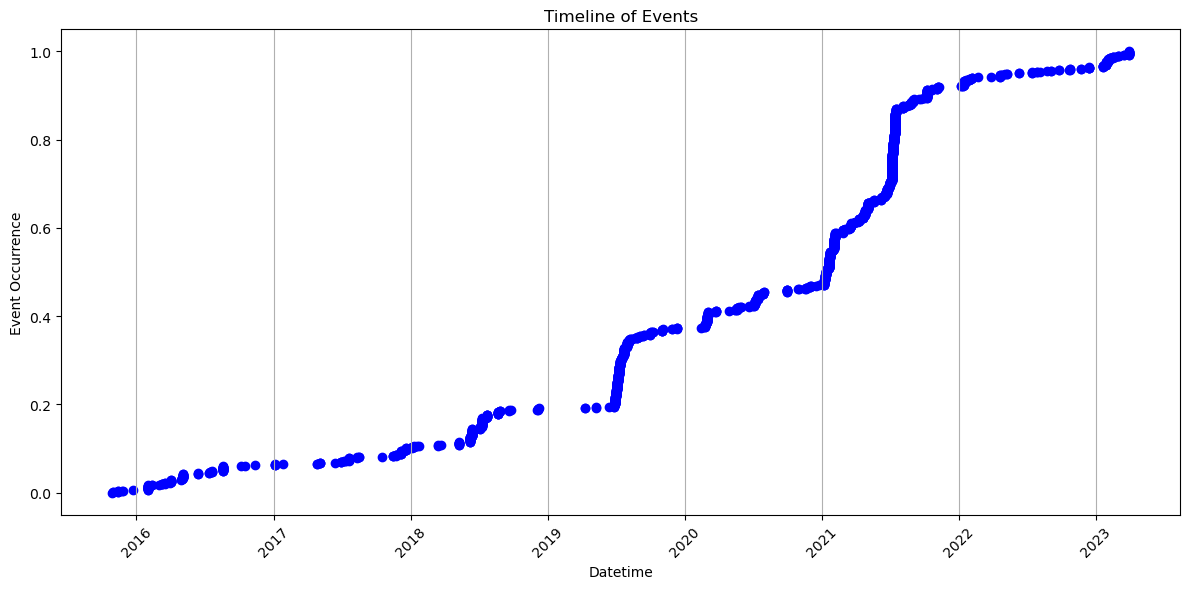

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure the 'Datetime' column is in datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Filter rows where 'Event' is not 'None'
df_events = df[df['Event'].notnull()]

# Sort the DataFrame by 'Datetime'
df_events = df_events.sort_values(by='Datetime')

# Create a y-axis position for each event to spread them out
# We'll alternate the y-axis position to avoid overlap
num_events = len(df_events)
y_positions = np.linspace(0, 1, num_events)  # Spread y-values slightly above and below 1

plt.figure(figsize=(12, 6))
plt.scatter(df_events['Datetime'], y_positions, marker='o', color='blue')

# # Add event descriptions as annotations with offsets
# for i, (idx, row) in enumerate(df_events.iterrows()):
#     plt.annotate(
#         row['Event'].decode('utf-8') if isinstance(row['Event'], bytes) else row['Event'],
#         (row['Datetime'], y_positions[i]),
#         textcoords="offset points",
#         xytext=(0, 10),
#         ha='center',
#         fontsize=9,
#         arrowprops=dict(arrowstyle='->', color='gray', lw=0.5)
#     )

# Formatting the plot
plt.title('Timeline of Events')
plt.xlabel('Datetime')
plt.ylabel('Event Occurrence')
plt.grid(axis='x')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Renset data oven på original data

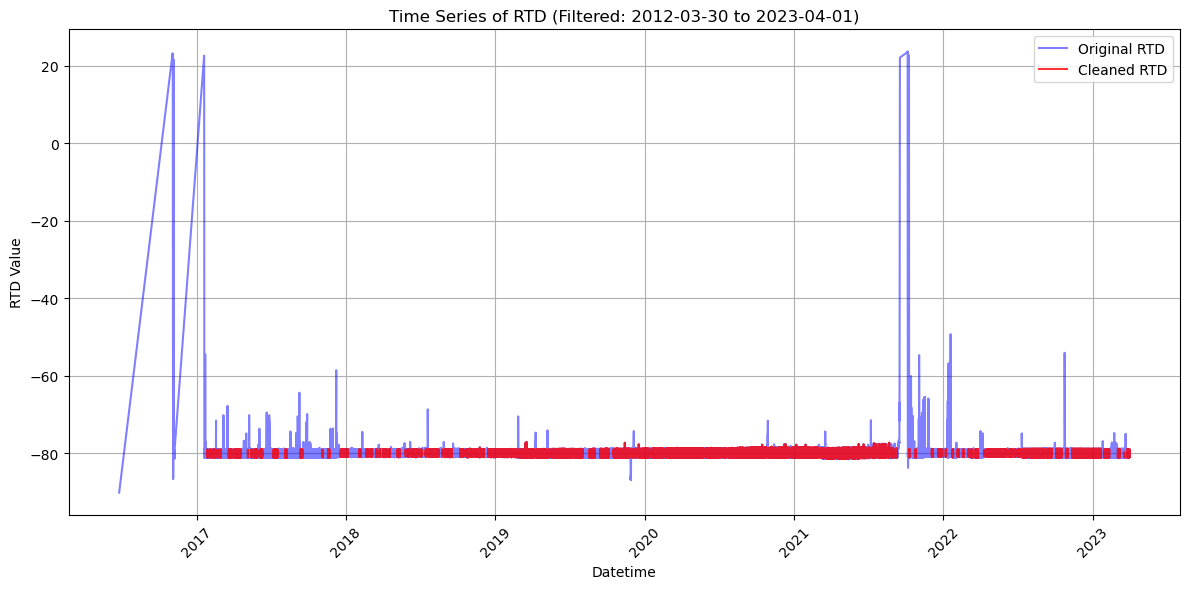

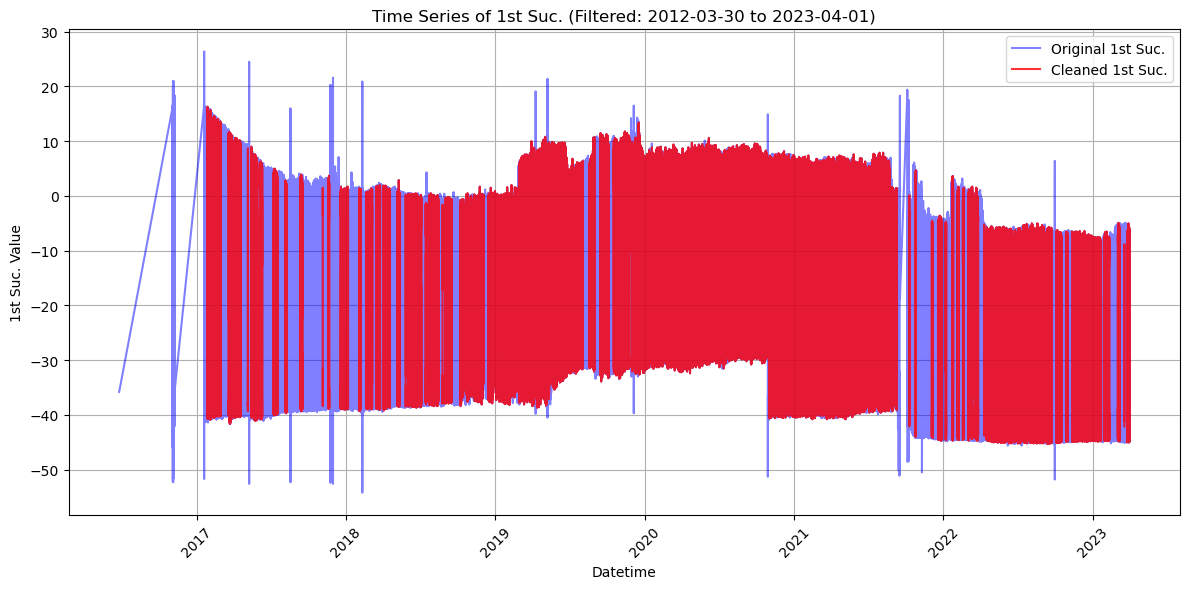

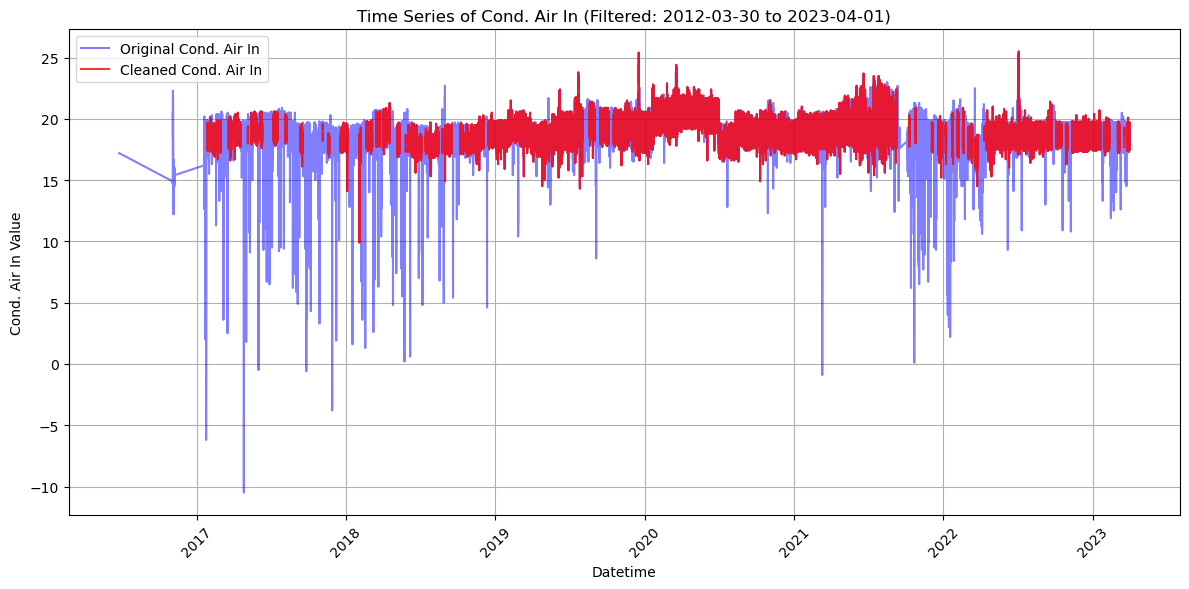

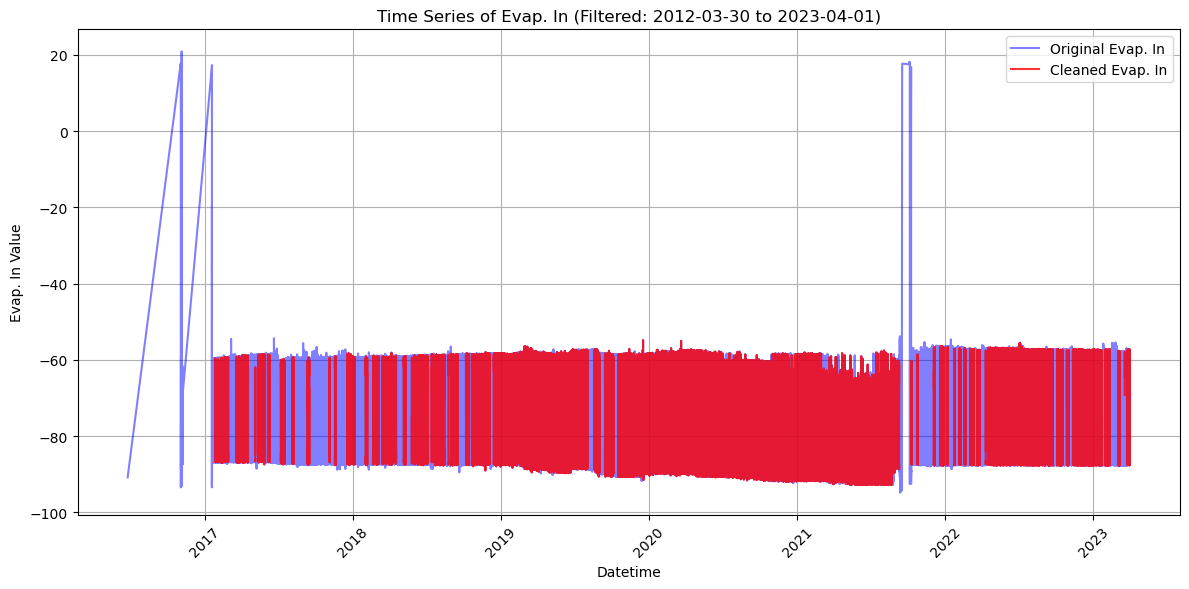

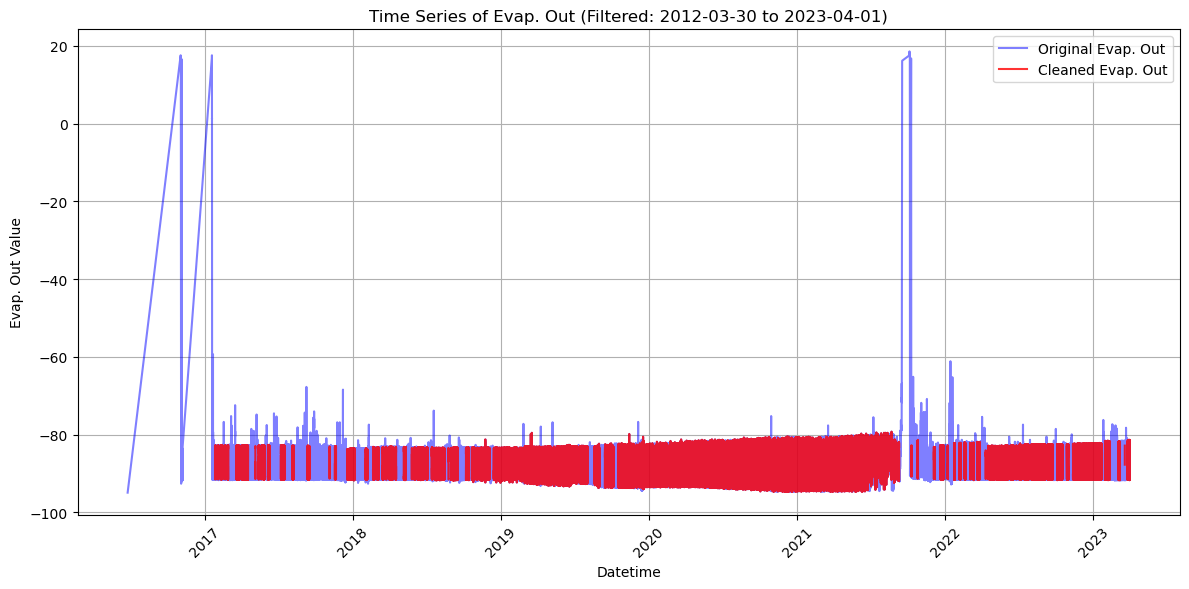

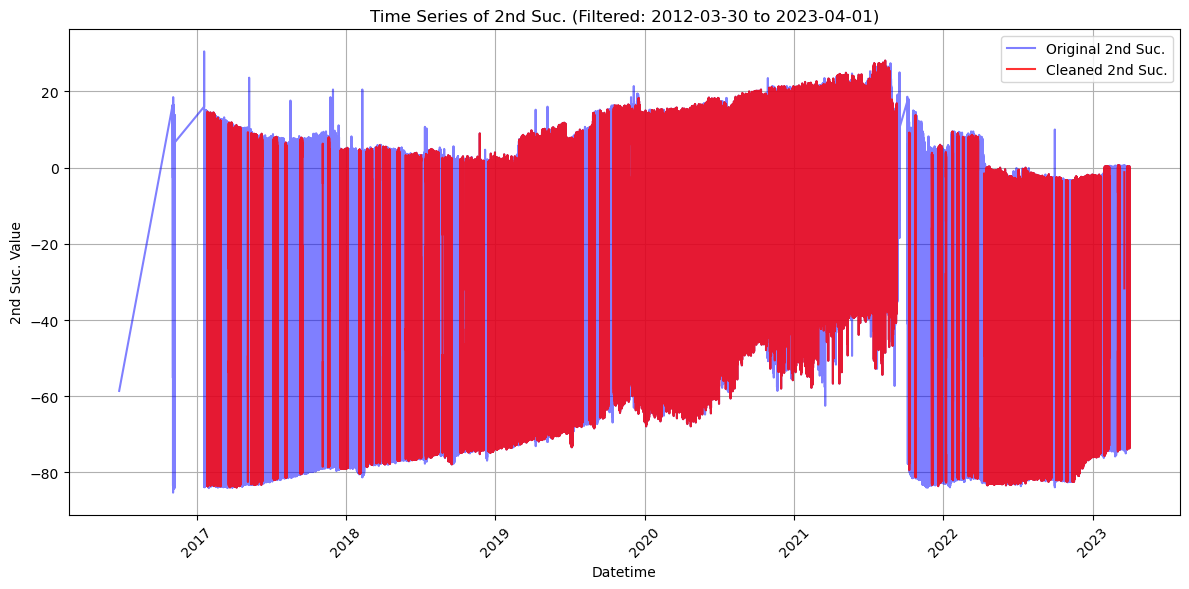

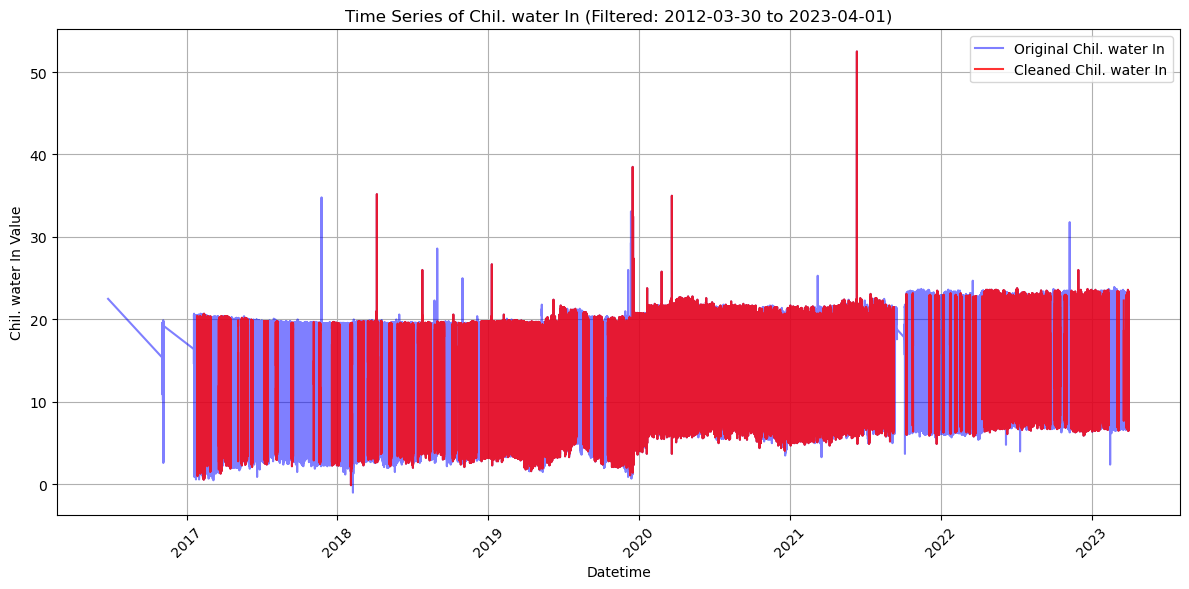

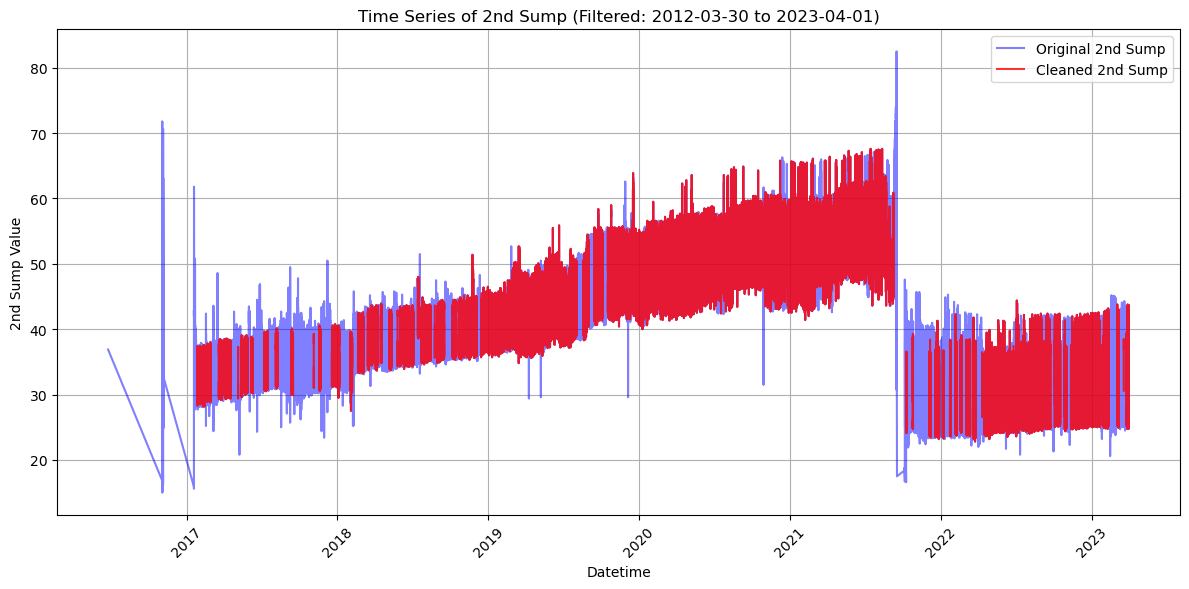

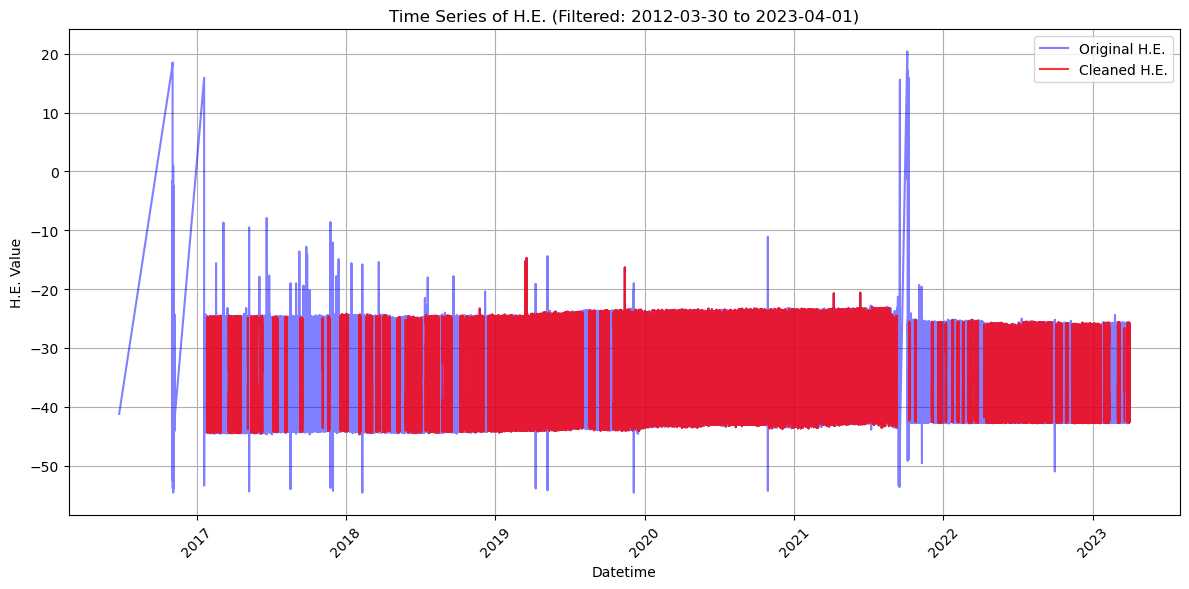

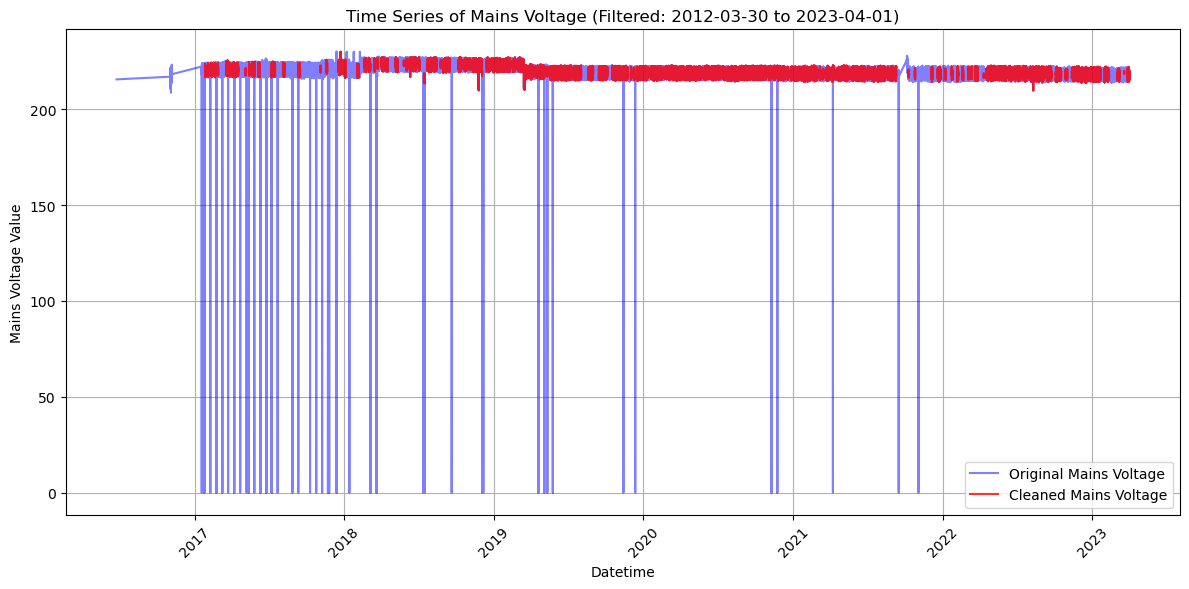

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Freezer_number = 806016

# Parameters
start_date = '2012-03-30'
end_date = '2023-04-01'

#start_date = '2017-09-30'
#end_date = '2018-10-01'

# Read the original and cleaned Parquet files into DataFrames
df_original = pd.read_parquet(path + str(Freezer_number) + '_temp.parquet')
df_cleaned = pd.read_parquet(path + 'cleaned_data_' + str(Freezer_number) + '.parquet')

# Convert 'Datetime' to datetime type if not already done
df_original['Datetime'] = pd.to_datetime(df_original['Datetime'])
df_cleaned['Datetime'] = pd.to_datetime(df_cleaned['Datetime'])

# Set 'Datetime' as the index for easier plotting
df_original.set_index('Datetime', inplace=True)
df_cleaned.set_index('Datetime', inplace=True)

# Filter both DataFrames to the specified date range
df_original_filtered = df_original.loc[start_date:end_date]
df_cleaned_filtered = df_cleaned.loc[start_date:end_date]

# Select only numeric columns for plotting (assuming both DataFrames have the same structure)
numeric_columns = df_cleaned_filtered.select_dtypes(include=['float64', 'int64']).columns

# Calculate time differences for the cleaned data to detect gaps
time_diffs = df_cleaned_filtered.index.to_series().diff().dt.total_seconds()

# Define a threshold (e.g., 2x the median difference) to detect large gaps
gap_threshold = 2 * time_diffs.median()

# Insert NaNs where gaps are detected in the cleaned data
df_cleaned_filtered.loc[time_diffs > gap_threshold, numeric_columns] = np.nan

# Plot each numeric column, overlaying cleaned data (red) on original data (blue)
for col in numeric_columns:
    plt.figure(figsize=(12, 6))
    
    # Plot original data in blue
    plt.plot(df_original_filtered.index, df_original_filtered[col], label=f'Original {col}', color='blue', alpha=0.5)
    
    # Plot cleaned data in red
    plt.plot(df_cleaned_filtered.index, df_cleaned_filtered[col], label=f'Cleaned {col}', color='red', alpha=0.8)
    
    # Customize plot appearance
    plt.title(f"Time Series of {col} (Filtered: {start_date} to {end_date})")
    plt.xlabel("Datetime")
    plt.ylabel(f"{col} Value")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

## Ren data

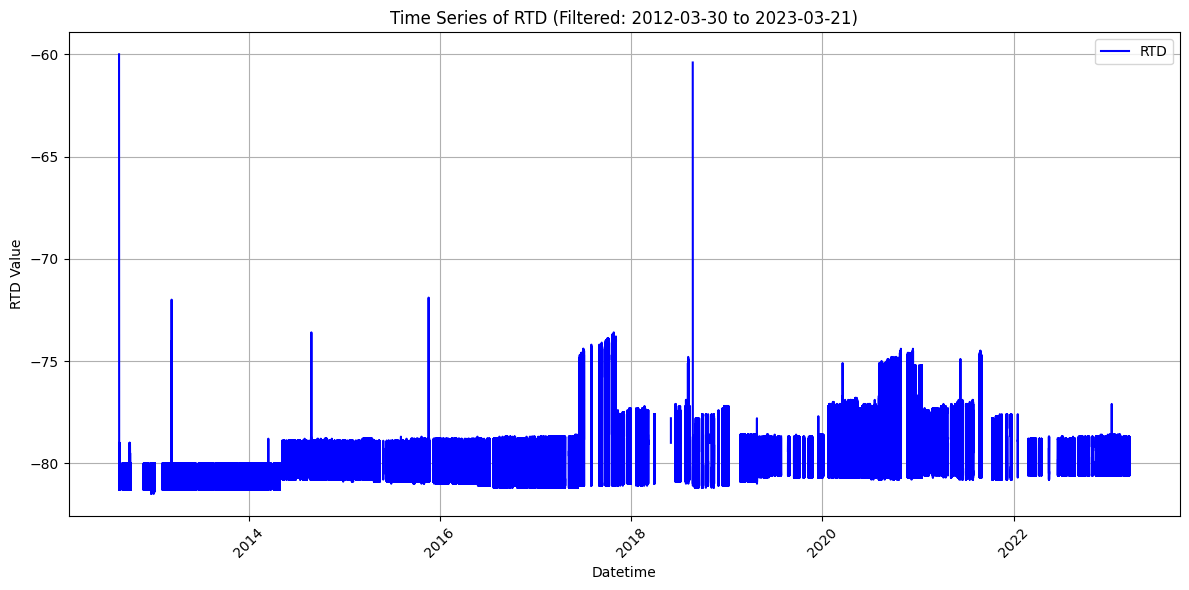

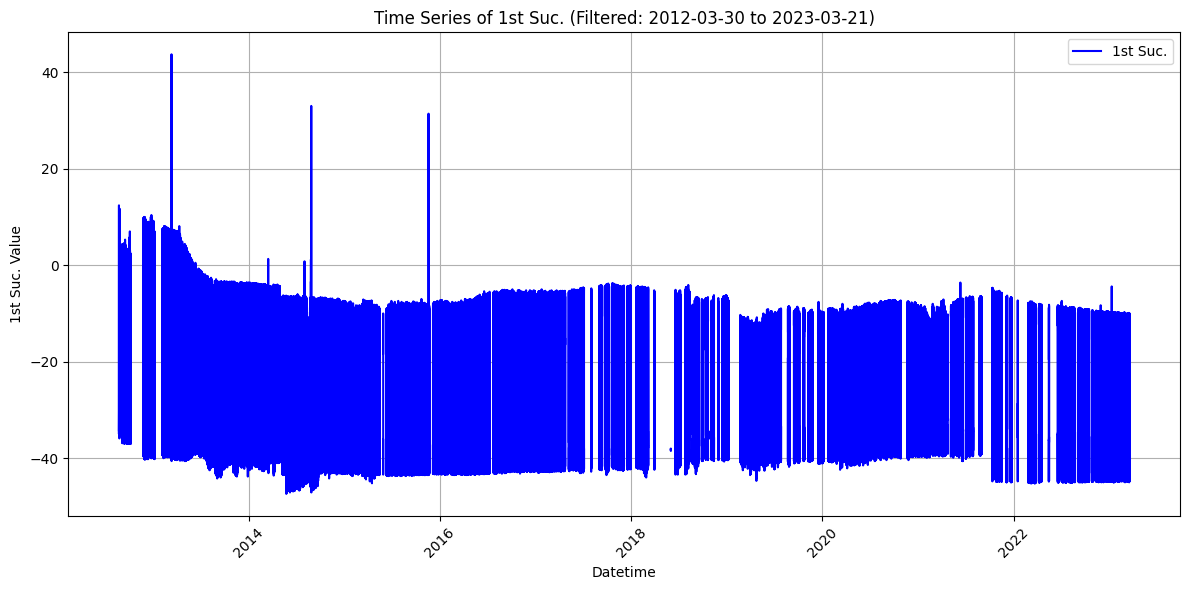

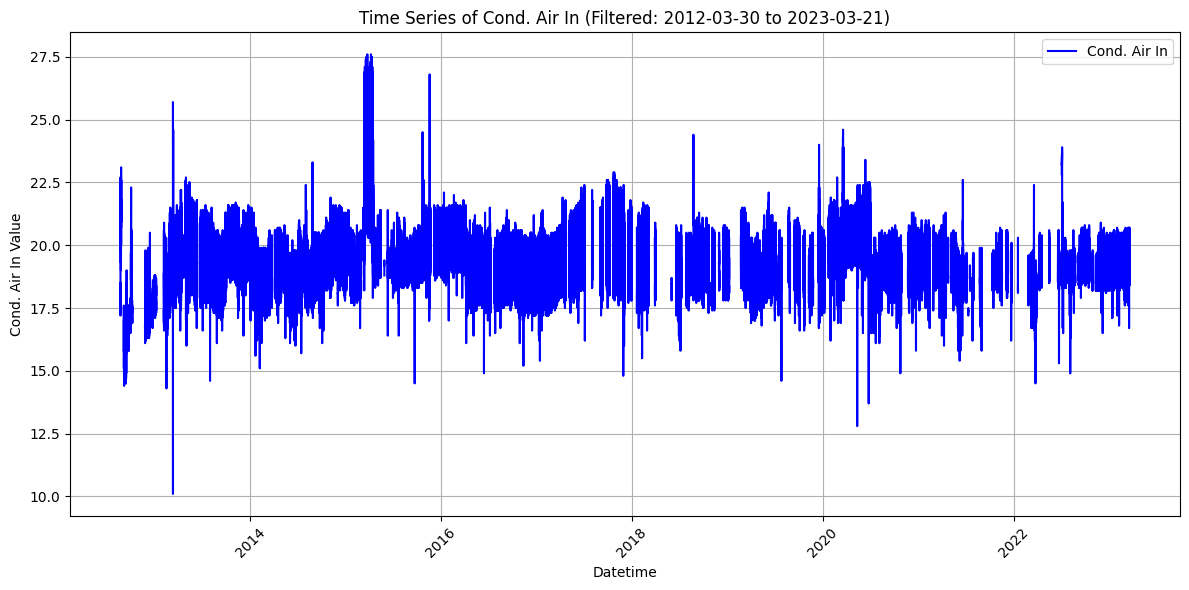

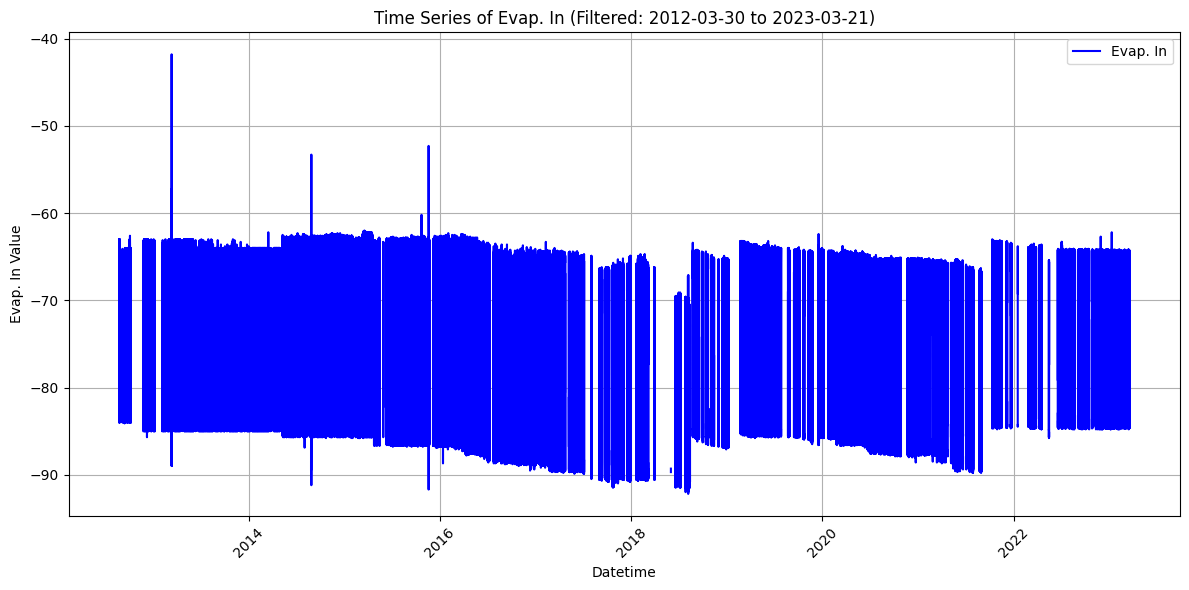

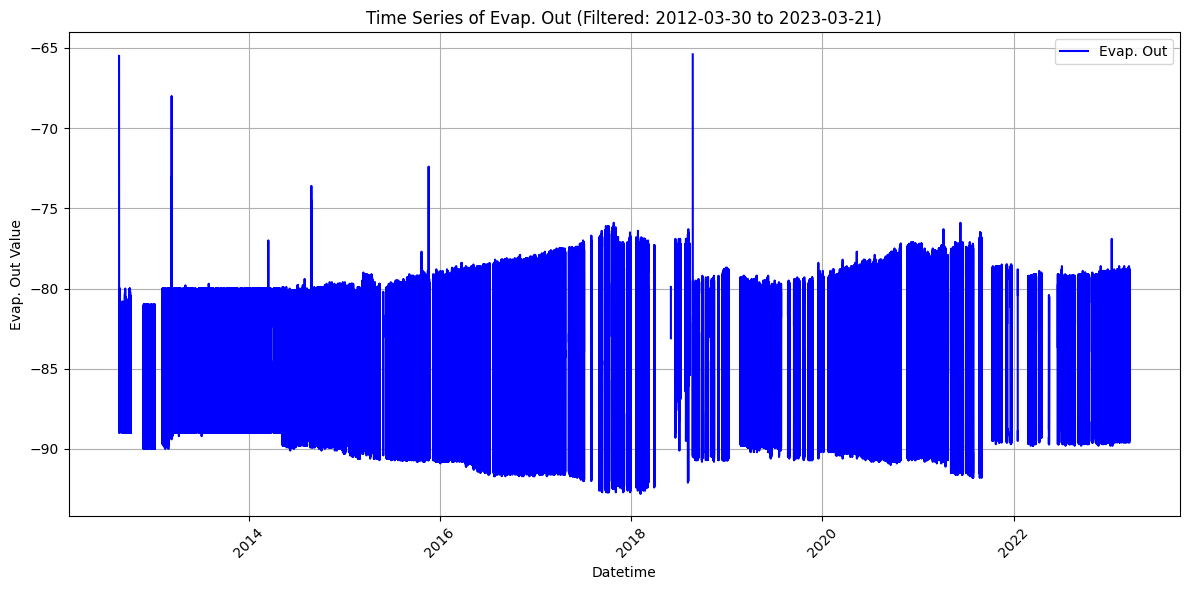

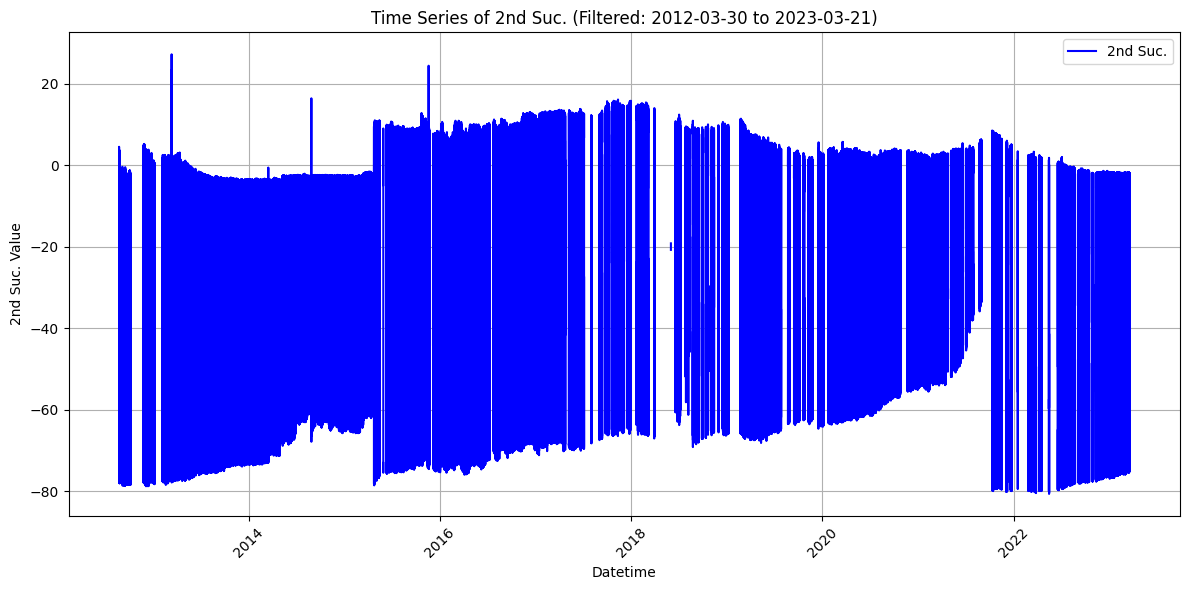

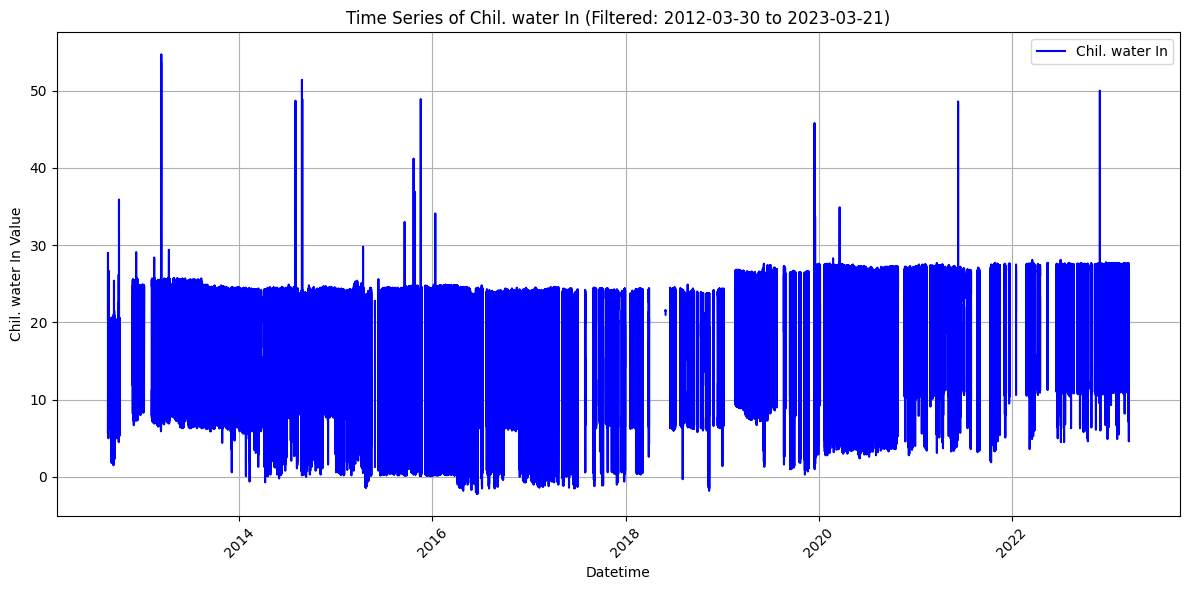

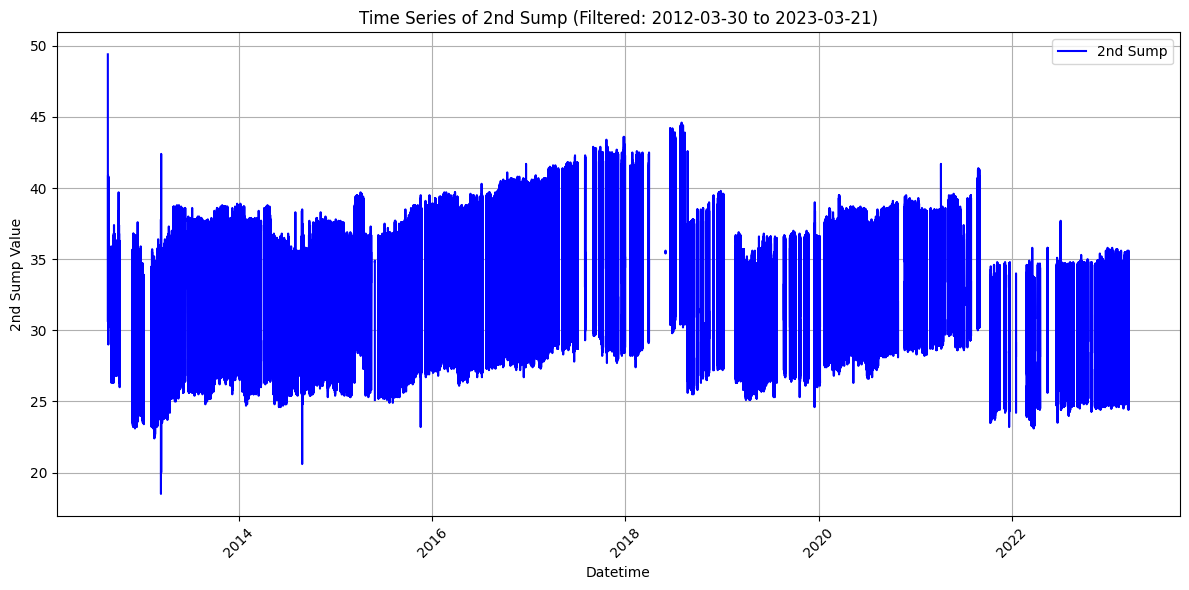

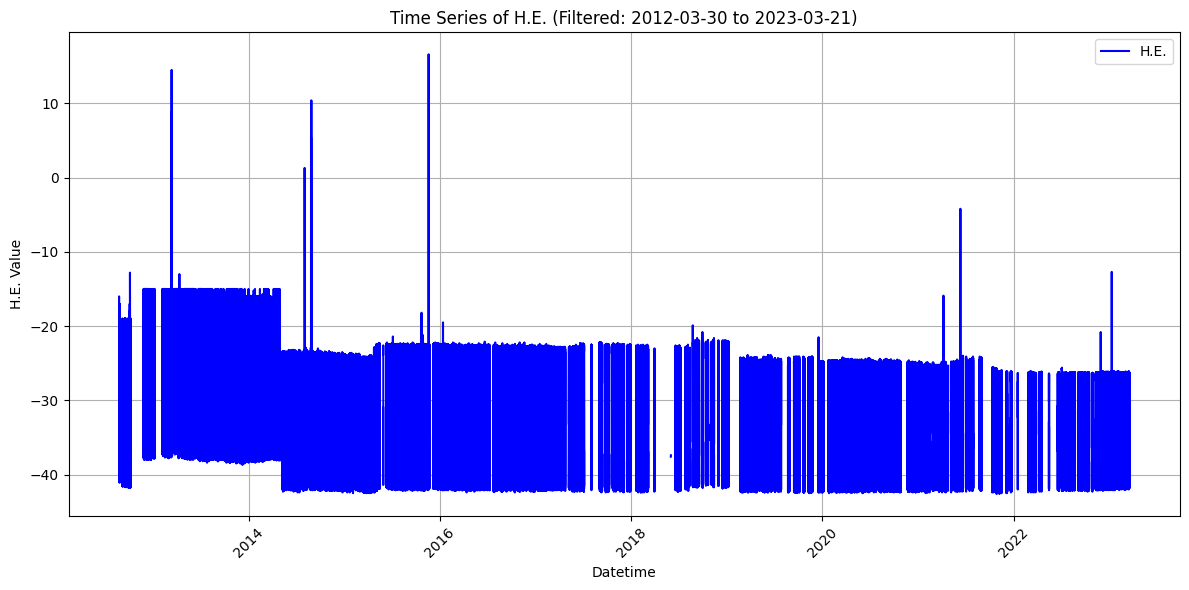

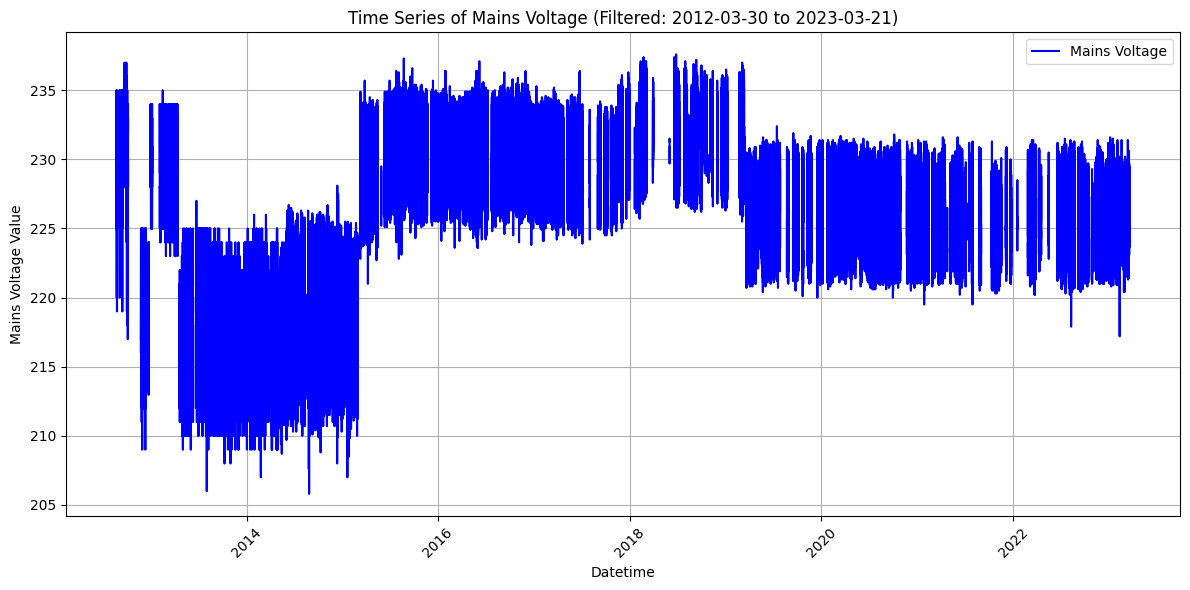

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parameters
start_date = '2012-03-30'
end_date = '2023-03-21'

# Read the cleaned Parquet file into a DataFrame
df = pd.read_parquet(path + 'cleaned_data_' + str(Freezer_number) + '.parquet')

# Convert 'Datetime' to datetime type if it's not already
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set 'Datetime' as the index for easier plotting
df.set_index('Datetime', inplace=True)

# Filter the DataFrame to the specified date range
df_filtered = df.loc[start_date:end_date]

# Select only numeric columns for plotting
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64']).columns

# Calculate time differences between consecutive rows
time_diffs = df_filtered.index.to_series().diff().dt.total_seconds()

# Define a threshold (e.g., 2x the median difference) to detect large gaps
gap_threshold = 2 * time_diffs.median()

# Insert NaNs where gaps are detected
df_filtered.loc[time_diffs > gap_threshold, numeric_columns] = np.nan

# Plot each numeric column separately
for col in numeric_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered.index, df_filtered[col], label=col, color='blue')
    
    plt.title(f"Time Series of {col} (Filtered: {start_date} to {end_date})")
    plt.xlabel("Datetime")
    plt.ylabel(f"{col} Value")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

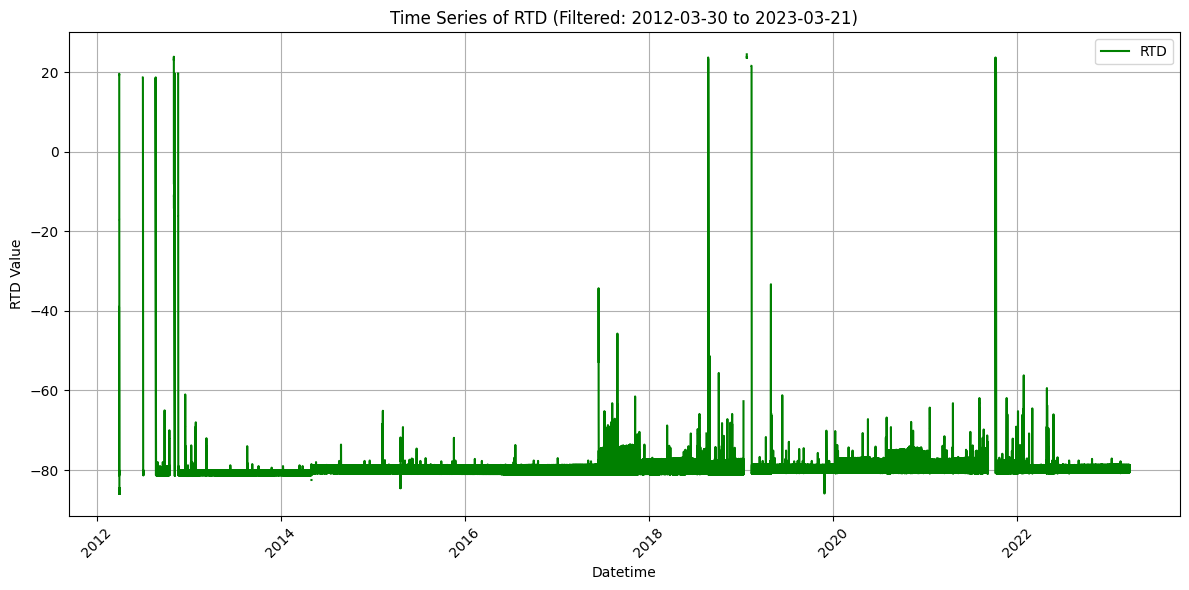

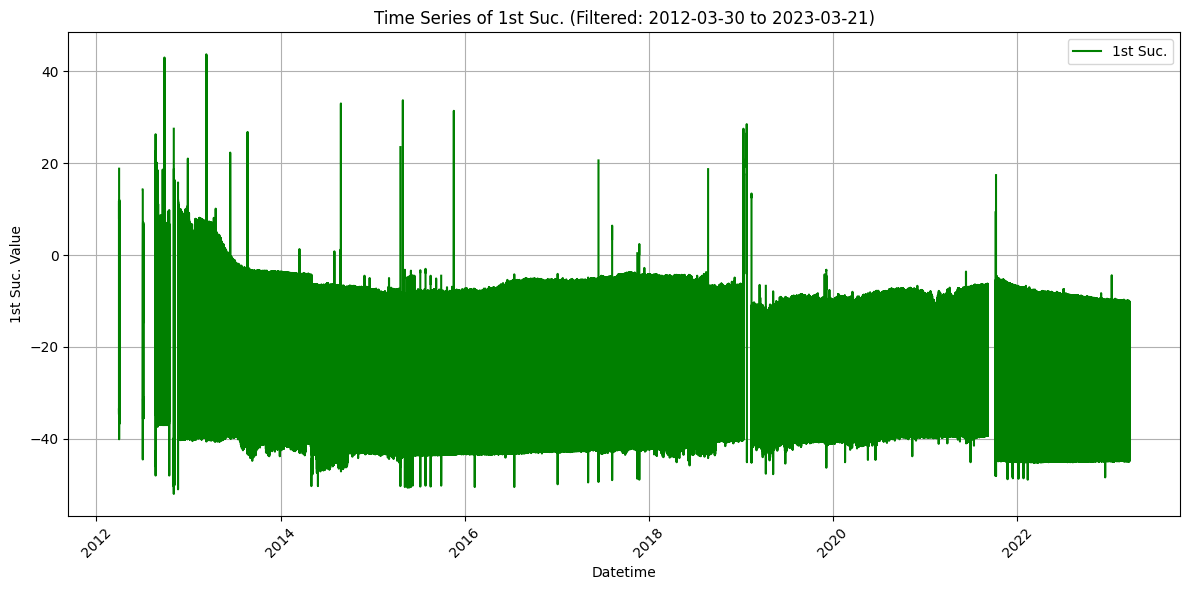

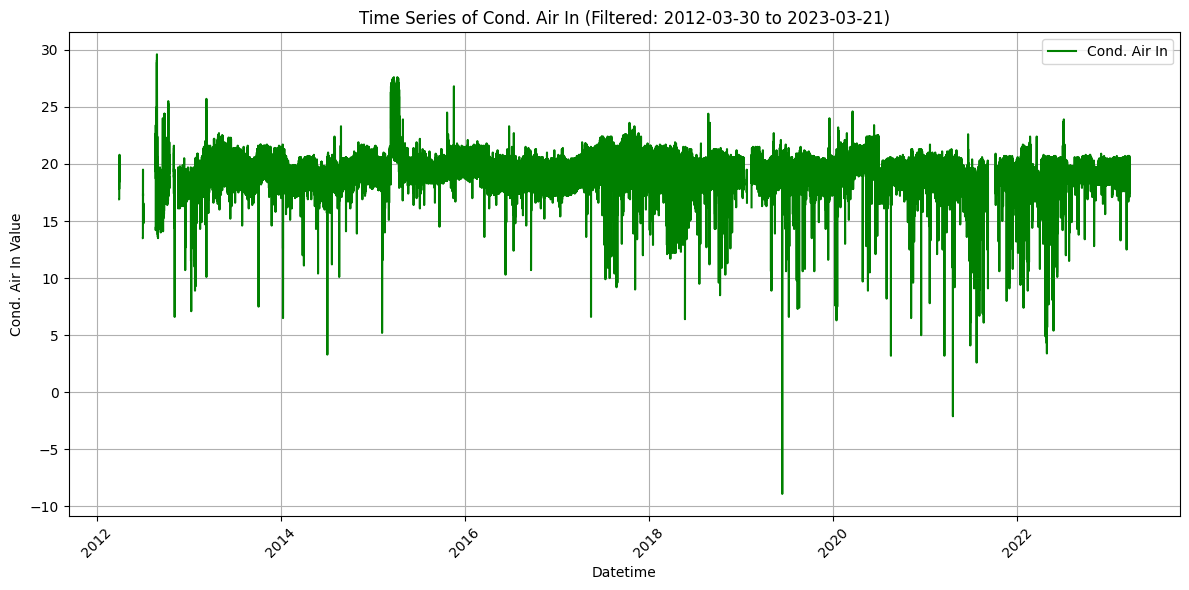

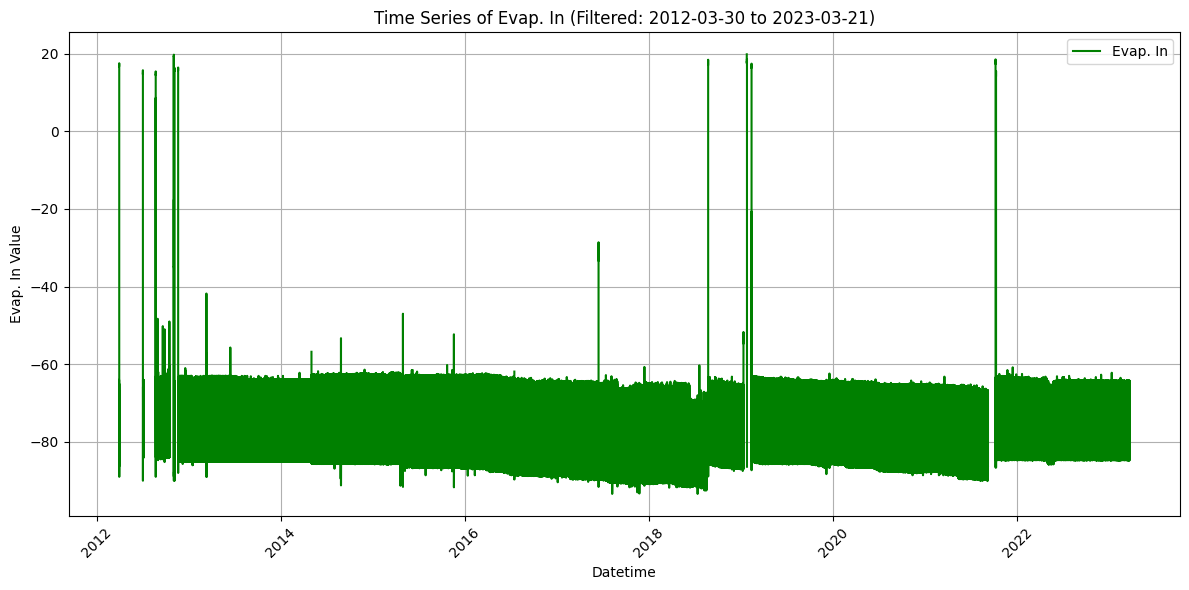

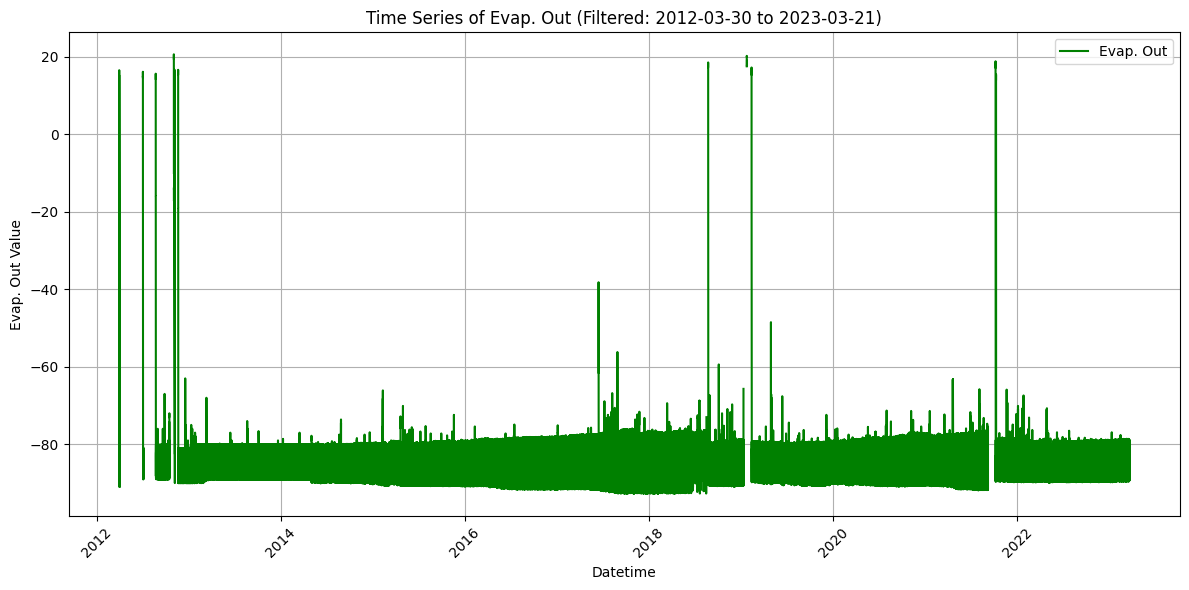

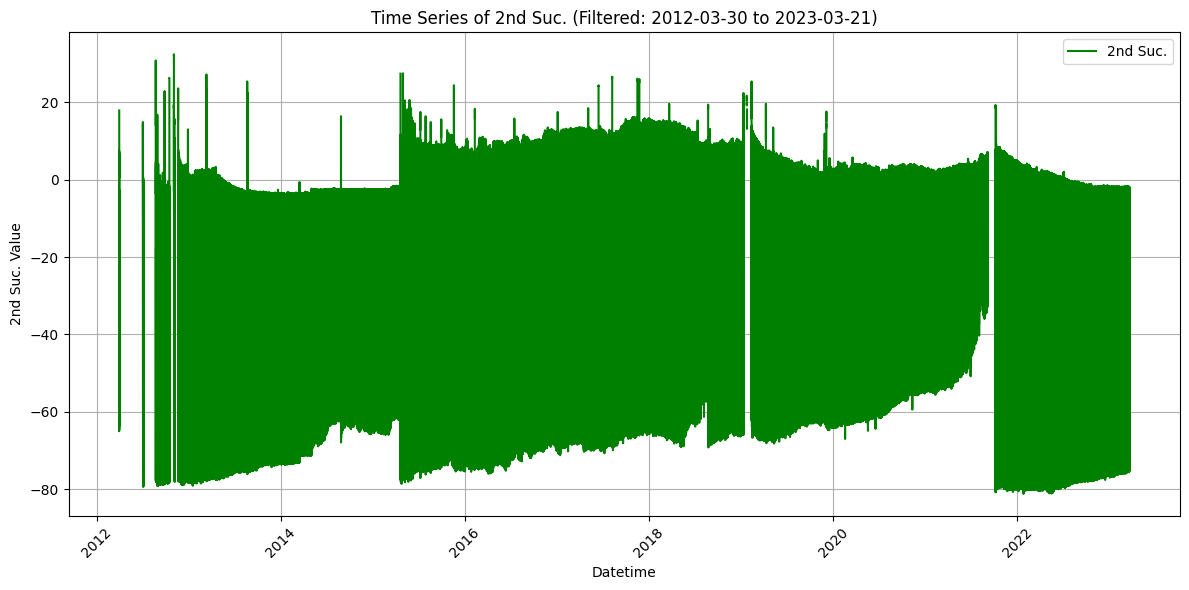

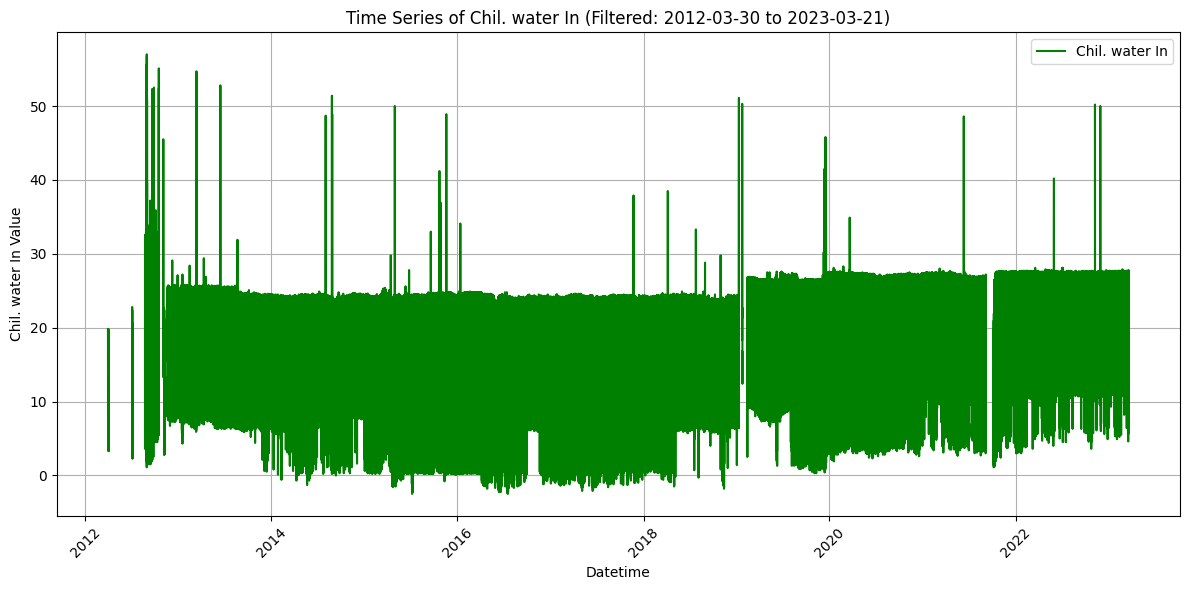

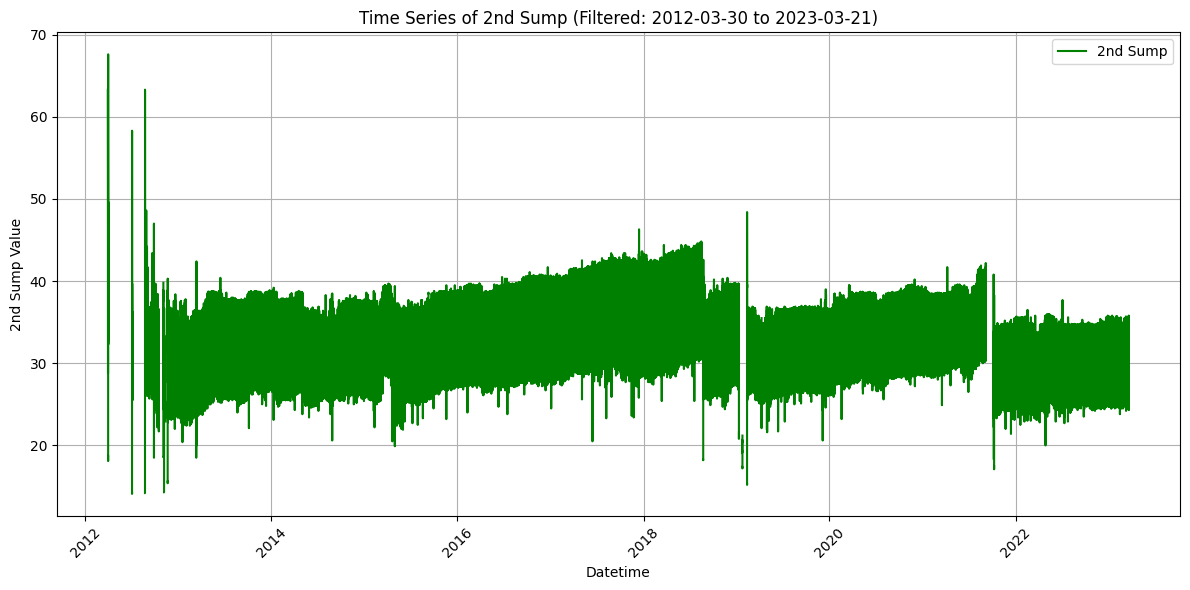

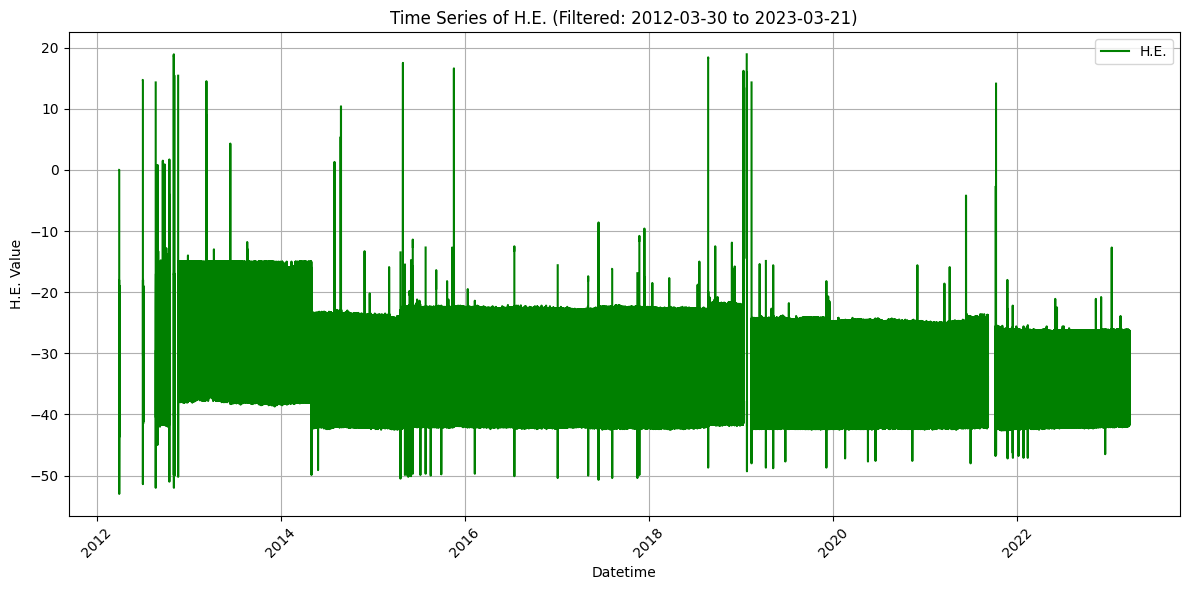

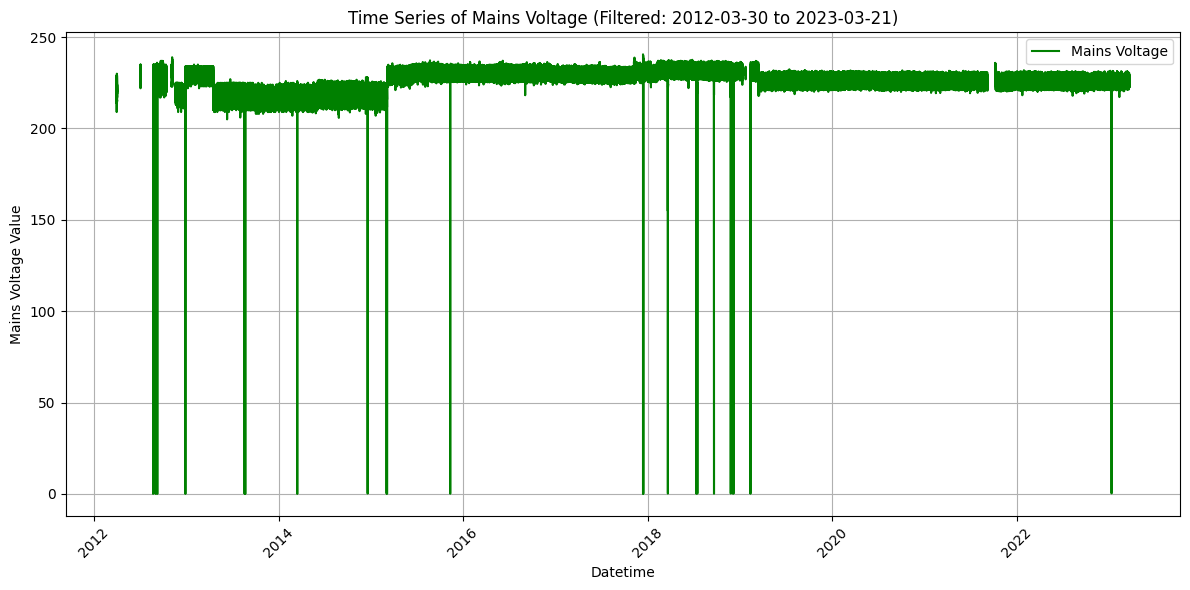

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parameters
start_date = '2012-03-30'
end_date = '2023-03-21'

# Read the cleaned Parquet file into a DataFrame
df = pd.read_parquet(path + str(Freezer_number) + '_temp.parquet')

# Convert 'Datetime' to datetime type if it's not already
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set 'Datetime' as the index for easier plotting
df.set_index('Datetime', inplace=True)

# Filter the DataFrame to the specified date range
df_filtered = df.loc[start_date:end_date]

# Select only numeric columns for plotting
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64']).columns

# Calculate time differences between consecutive rows
time_diffs = df_filtered.index.to_series().diff().dt.total_seconds()

# Define a threshold (e.g., 2x the median difference) to detect large gaps
gap_threshold = 2 * time_diffs.median()

# Insert NaNs where gaps are detected
df_filtered.loc[time_diffs > gap_threshold, numeric_columns] = np.nan

# Plot each numeric column separately
for col in numeric_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered.index, df_filtered[col], label=col, color='green')
    
    plt.title(f"Time Series of {col} (Filtered: {start_date} to {end_date})")
    plt.xlabel("Datetime")
    plt.ylabel(f"{col} Value")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()